In [1]:
using Revise
includet("paper.jl")

using Gnuplot
import Base.show
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")

using DataFrames, DataFramesMeta, CSV
using JLD2
using DelimitedFiles
#jldr = JLD2.load("modeloutputs.jld2")

In [201]:
modelresults, data, popsize = run_model(;iter=40000, ag45=true)
max_ag, max_t, max_d = size(data) # maximum age group, time, vaccine 
println("dimensions: max_ag: $max_ag, max_t: $max_t, max_d: $max_d")
modelresults

running model - ag45: true


┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/affans/.julia/packages/Turing/lkUBK/src/mcmc/hmc.jl:191


dimensions: max_ag: 7, max_t: 21, max_d: 2


Chains MCMC chain (40000×41×1 Array{Float64, 3}):

Iterations        = 1001:1:41000
Number of chains  = 1
Samples per chain = 40000
Wall duration     = 107.14 seconds
Compute duration  = 107.14 seconds
parameters        = ρ[1], ρ[2], ρ[3], ρ[4], ρ[5], ρ[6], ρ[7], b[1], b[2], b[3], b[4], b[5], b[6], b[7], b[8], b[9], b[10], b[11], b[12], b[13], b[14], b[15], b[16], b[17], b[18], b[19], b[20], b[21], θ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk     ess_tail      rhat ⋯
      Symbol    Float64   Float64   Float64     Float64      Float64   Float64 ⋯

        ρ[1]   -11.2435    0.1027    0.0015   4811.9565    7989.9408    1.0000 ⋯
        ρ[2]   -12.5826    0.1021    0.0015   4795.9625    8113.0943    1.0000 ⋯
        ρ[3]   -13.5122    0.1068    0.0015   5

### Description of the model/results
The output of `modelresults` includes the Bayesian inference of all the parameters of the model specifically the posterior distributions of :ρ, β, and θ. The output also includes the posterior predictive checks.

In [202]:

# we need to turn thetha off to turn off the vaccine effects
# have to get to the internals of the model to turn off thetha 
rho, rhoquants = describe(group(modelresults, :ρ)) .|> DataFrame
beta, betaquants = describe(group(modelresults, :b)) .|> DataFrame
theta, thetaquants = describe(group(modelresults, :θ)) .|> DataFrame

# means and quantiles
rmeans = rho.mean
bmeans = beta.mean
tmeans = theta.mean
rupper = rhoquants[!, Symbol("97.5%")]
rlower = rhoquants[!, Symbol("2.5%")]
bupper = betaquants[!, Symbol("97.5%")]
blower = betaquants[!, Symbol("2.5%")]
tupper = thetaquants[!, Symbol("97.5%")]
tlower = thetaquants[!, Symbol("2.5%")]

# write the code to get the results 
poster = similar(data, Float64)
poster_upper = similar(data, Float64)
poster_lower = similar(data, Float64)

poster_thetaon = similar(data, Float64)
poster_upper_thetaon = similar(data, Float64)
poster_lower_thetaon = similar(data, Float64)
for d = 1:max_d
    for t = 1:max_t
        for ag = 1:max_ag
            if d == 1 # no vaccine 
                λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t] #bmeans[t]
                λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t]
                λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t]
                poster[ag, t, d] = mean(Poisson(exp(λ)))
                poster_upper[ag, t, d] = mean(Poisson(exp(λᵤ)))
                poster_lower[ag, t, d] = mean(Poisson(exp(λₗ)))

                # since theta = 0 by definition
                poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                poster_upper_thetaon[ag, t, d] = mean(Poisson(exp(λᵤ)))
                poster_lower_thetaon[ag, t, d] = mean(Poisson(exp(λₗ)))
                
            else 
                if popsize[ag, t, d] > 0 
                    λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t] #+ tmeans[1]
                    λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t]# + tupper[1]
                    λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t]# + tlower[1]
                    poster[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_upper[ag, t, d] = mean(Poisson(exp(λᵤ)))
                    poster_lower[ag, t, d] = mean(Poisson(exp(λₗ)))

                    λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t] + tmeans[1]
                    λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t] + tupper[1]
                    λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t] + tlower[1]
                    poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_upper_thetaon[ag, t, d] = mean(Poisson(exp(λᵤ)))
                    poster_lower_thetaon[ag, t, d] = mean(Poisson(exp(λₗ)))
                else 
                    poster[ag, t, d] = mean(Poisson(0))
                    poster_upper[ag, t, d] = mean(Poisson(0))
                    poster_lower[ag, t, d] = mean(Poisson(0))

                    poster_thetaon[ag, t, d] = mean(Poisson(0))
                    poster_upper_thetaon[ag, t, d] = mean(Poisson(0))
                    poster_lower_thetaon[ag, t, d] = mean(Poisson(0))
                end 
                # λ = log(K[ag, t, d] + 1) + ρ[ag] + b[t] + θ
                # data[ag, t, d] ~ Poisson(exp(λ)) 
            end
            #poster[ag, t, d] = mean(Poisson(exp(λ)))
        end
    end
end
total_mean_manual = dropdims(sum(poster, dims=3);dims=3)
total_mean_upper = dropdims(sum(poster_upper, dims=3);dims=3)
total_mean_lower = dropdims(sum(poster_lower, dims=3);dims=3)

total_mean_thetaon = dropdims(sum(poster_thetaon, dims=3);dims=3)
total_mean_upper_thetaon = dropdims(sum(poster_upper_thetaon, dims=3);dims=3)
total_mean_lower_thetaon = dropdims(sum(poster_lower_thetaon, dims=3);dims=3)

# check the difference between manual calculation and automatic predict function (should be the same or close enough)
# total_mean_manual - total_mean
function generate_df_from_poster(p) 
    # _novax = reshape(p[:, :, 1], (120)) # I think this shapes it correctly 
    # _wivax = reshape(p[:, :, 2], (120))
    # vcat(_novax, _wivax)
    reshape(p, (max_t * max_ag))
end
_thethaoff_df = DataFrame(idx = 1:(max_t * max_ag),
                        mean_thetaon = generate_df_from_poster(total_mean_thetaon),
                        lower_thetaon = generate_df_from_poster(total_mean_lower_thetaon),
                        upper_thetaon = generate_df_from_poster(total_mean_upper_thetaon),
                        mean_thetaoff = generate_df_from_poster(total_mean_manual),
                        lower_thetaoff = generate_df_from_poster(total_mean_lower), 
                        upper_thetaoff = generate_df_from_poster(total_mean_upper))

CSV.write("./output/bayesian_modelresults_ag45.csv", _thethaoff_df)
_thethaoff_df
# #newdf = DataFrame(a = meandf.mean[1:120], b = generate_df_from_poster(poster)[1:120])
# #outerjoin(mean_and_quants, _thethaoff_df, on=:parameters)


Row,idx,mean_thetaon,lower_thetaon,upper_thetaon,mean_thetaoff,lower_thetaoff,upper_thetaoff
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,78.7008,53.054,116.945,78.7008,53.054,116.945
2,2,78.5706,52.9701,116.765,78.5706,52.9701,116.765
3,3,49.6073,33.1673,74.2602,49.6073,33.1673,74.2602
4,4,308.78,210.352,454.345,308.78,210.352,454.345
5,5,289.301,197.473,423.984,289.301,197.473,423.984
6,6,146.313,99.5437,215.258,146.313,99.5437,215.258
7,7,240.28,163.758,352.529,240.28,163.758,352.529
8,8,54.1034,36.3538,80.4842,54.1034,36.3538,80.4842
9,9,55.5401,37.3218,82.631,55.5401,37.3218,82.631


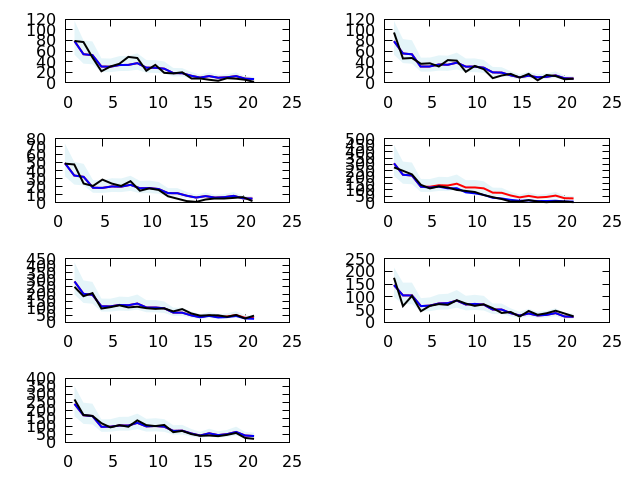

In [203]:
# plot the manual posterior calculation 
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 800,800")
@gp "reset" 
@gp :- "set multiplot layout 4,2 "

# plot the bayesian model results 
for i = 1:max_ag
    @gp :- i 1:max_t total_mean_lower[i, :] total_mean_upper[i, :] "with filledcu notitle lc rgb '#e5f5f9'"
end

for i = 1:max_ag
    @gp :- i 1:max_t total_mean_manual[i, :] "with lines notitle lw 2 lc 'red'" :-
end

for i = 1:max_ag
    @gp :- i 1:max_t total_mean_thetaon[i, :] "with lines notitle lw 2 lc 'blue'" :-
end
# plot the data
for i = 1:max_ag
    @gp :- i 1:max_t (data[i, :, 1] + data[i, :, 2]) "with lines notitle lw 2 lc 'black'" :-
end
display(@gp)

plotting traceplot: itertions: 40000


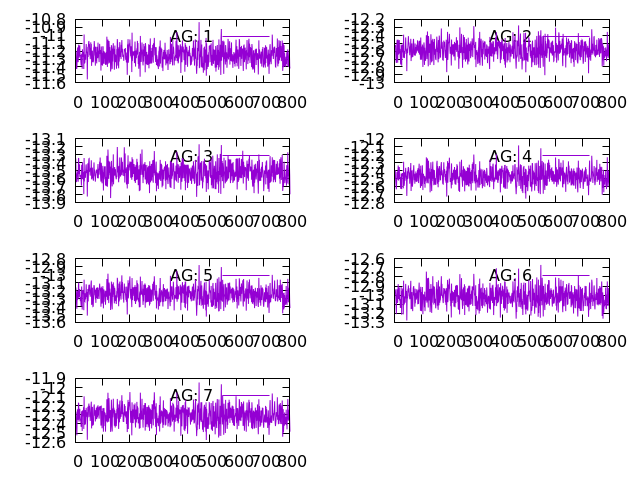

In [204]:
val = get(modelresults, [:ρ, :b, :θ])

println("plotting traceplot: itertions: $(length(val.ρ[1].data))")
# don't plot all 40,000 
@gp "reset" 
@gp :- "set multiplot layout 4,2 "
for g = 1:max_ag
    @gp :- g 1:length(val.ρ[g].data[1:50:40000]) val.ρ[g].data[1:50:40000] "with lines title 'AG: $(g)" :- 
end 
display(@gp)

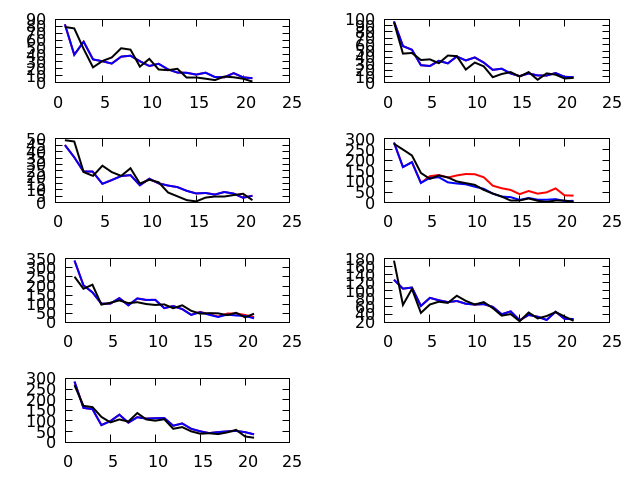

BoundsError: BoundsError: attempt to access 147×1000 Matrix{Float64} at index [[4, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100, 108, 116, 124, 132, 140, 148, 156, 164], 1:1000]

In [205]:
# similar to above but sample from the distributions 
# write the code to get the results 
function sample_curves() 
    val = get(modelresults, [:ρ, :b, :θ])   
    # this function returns one single realization 
    poster = similar(data, Float64)
    poster_thetaon = similar(data, Float64)
    for d = 1:max_d
        for t = 1:max_t
            for ag = 1:max_ag
                # sample the numbers 
                rsamp = rand(val.ρ[ag].data)
                bsamp = rand(val.b[t].data)
                tsamp = rand(val.θ.data)
                if d == 1 # no vaccine 
                    λ = log(popsize[ag, t, d]) + rsamp + bsamp
                    poster[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_thetaon[ag, t, d] = mean(Poisson(exp(λ))) # since theta = 0 by definition

                else 
                    if popsize[ag, t, d] > 0 
                        λ = log(popsize[ag, t, d]) + rsamp + bsamp #+ tmeans[1]
                        poster[ag, t, d] = mean(Poisson(exp(λ)))
                        
                        λ = log(popsize[ag, t, d]) + rsamp + bsamp + tsamp
                        poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                    else 
                        poster[ag, t, d] = mean(Poisson(0))
                        poster_thetaon[ag, t, d] = mean(Poisson(0))
                    end 
                end
            end
        end
    end
    # sum the infections (due to no vaccine subgroup and vaccine subgroup together) 
    total_inf_thetaoff = dropdims(sum(poster, dims=3);dims=3)
    total_inf_thetaon = dropdims(sum(poster_thetaon, dims=3);dims=3)

    return total_inf_thetaoff, total_inf_thetaon
end
total_inf_thetaoff, total_inf_thetaon = sample_curves()
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 800,800")
@gp "reset" 
@gp :- "set multiplot layout 4,2 "
for i = 1:max_ag
    @gp :- i 1:max_t total_inf_thetaoff[i, :] "with lines notitle lw 2 lc 'red'" :-
end

for i = 1:max_ag
    @gp :- i 1:max_t total_inf_thetaon[i, :] "with lines notitle lw 2 lc 'blue'" :-
end
# plot the data
for i = 1:max_ag
    @gp :- i 1:max_t (data[i, :, 1] + data[i, :, 2]) "with lines notitle lw 2 lc 'black'" :-
end
display(@gp)


# use the above function to sample 1000 curves 
nsims = 1000
curves_thetaon = zeros(Float64, max_ag*max_t, nsims)
curves_thetaoff = zeros(Float64, max_ag*max_t, nsims)
for i = 1:nsims 
    _total_inf_thetaoff, _total_inf_thetaon = sample_curves()
    total_inf_thetaoff = vec(_total_inf_thetaoff)
    total_inf_thetaon = vec(_total_inf_thetaon)
    curves_thetaoff[:, i] .= total_inf_thetaoff
    curves_thetaon[:, i] .= total_inf_thetaon
end
writedlm("./output/sampled_curves_thetaoff.csv", curves_thetaoff, ',')
writedlm("./output/sampled_curves_thetaon.csv", curves_thetaon, ',')

# fix code if using consolidated age groups 4 and 5
diff = abs.(curves_thetaon .- curves_thetaoff)
ag4_idx = collect(4:8:168)
ag4_diff = diff[ag4_idx, :]
ag4_cumdiff = vec(sum(ag4_diff, dims=1))
ag4_mean = mean(ag4_cumdiff)
ag4_quants = quantile(ag4_cumdiff, [0.025, 0.975])
println("mean: $(ag4_mean), quantiles: $(ag4_quants)")